## Web Cam Display Test

In [1]:
def remove_extremes(data):
    """
    Removes the two largest and two smallest elements from the list and returns the processed list.
    
    :param data: Input list
    :return: List after removing extreme values
    """
    if len(data) <= 4:
        raise ValueError("The list must have more than 4 elements to remove the two largest and two smallest values.")
    
    # Sort the list and remove the two smallest and two largest elements
    sorted_data = sorted(data)
    return sorted_data[2:-2]


In [1]:
import cv2

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("无法打开摄像头")
else:
    # 设置分辨率（例如 1280x720）
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    # 再次获取帧率
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"{fps} FPS")

cap.release()


30.0 FPS


In [54]:
import cv2

cap = cv2.VideoCapture(0)

# 設置解析度
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# 獲取實際的解析度
actual_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
actual_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

print(f"Requested resolution: 1280x720")
print(f"Actual resolution: {int(actual_width)}x{int(actual_height)}")

cap.release()


Requested resolution: 1280x720
Actual resolution: 1280x720


In [57]:
import cv2

cam = cv2.VideoCapture(0)
default_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
default_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Default resolution: {default_width}x{default_height}")

cam.release()


Default resolution: 640x480


In [49]:
def display_cv2():
    processing_time = []
    
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    try:
        while True:
            start_time = time.time()
            
            ret, frame = cam.read()
            if not ret:
                print("Failed to capture image.")
                break

            processing_time.append(time.time() - start_time)
            if (len(processing_time) > 20):
                processing_time.pop(0)

            cv2.imshow("Image", frame)

            # Use waitKey with a check for interrupt signal
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        print("Interrupted by user.")
        processing_time = remove_extremes(processing_time)
        print(f"Processing Time: {sum(processing_time)/len(processing_time) * 1000:.2f} ms")
        print(processing_time)
    finally:
        cam.release()
        cv2.destroyAllWindows()

In [50]:
display_cv2()

Interrupted by user.
Processing Time: 23.66 ms
[0.0020041465759277344, 0.002069711685180664, 0.0021598339080810547, 0.002348661422729492, 0.0023729801177978516, 0.002555370330810547, 0.002753019332885742, 0.002818584442138672, 0.0028731822967529297, 0.0029785633087158203, 0.002984762191772461, 0.0030024051666259766, 0.07203364372253418, 0.08170461654663086, 0.09563493728637695, 0.09827399253845215]


# Segmentation

## Mediapipe - Selfie Segmentation

MediaPipe Selfie Segmentation segments the prominent humans in the scene. It can run in real-time on both smartphones and laptops. The intended use cases include selfie effects and video conferencing, where the person is close (< 2m) to the camera.

### Models
In this solution, we provide two models: general and landscape. Both models are based on **MobileNetV3**, with modifications to make them more efficient. The general model operates on a 256x256x3 (HWC) tensor, and outputs a 256x256x1 tensor representing the segmentation mask. The landscape model is similar to the general model, but operates on a 144x256x3 (HWC) tensor. It has fewer FLOPs than the general model, and therefore, runs faster. Note that MediaPipe Selfie Segmentation **automatically resizes the input image** to the desired tensor dimension before feeding it into the ML models.

- [Docoment 1](https://ai.google.dev/edge/mediapipe/solutions/guide) 
- [Docoment 2](https://chuoling.github.io/mediapipe/) 

###### Import

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
import time

### Image Segementation

In [14]:
def mediapipe_segmentation(img_path, threshold = 0.5):
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    plt.figure(figsize=(15,6))
    
    # display original image
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, 1)
    plt.imshow(image_rgb)

    # display mask
    result = selfie_segmentation.process(image_rgb)
    mask = result.segmentation_mask
    plt.subplot(2, 2, 2)
    plt.imshow(mask, cmap='gray')

    # display foreground and background
    foreground = image_rgb.copy()
    foreground[mask < threshold] = 0
    
    
    plt.subplot(2, 2, 3)
    plt.imshow(foreground)
    
    background = image_rgb.copy()
    background[mask > threshold] = 0
    
    plt.subplot(2, 2, 4)
    plt.imshow(background)

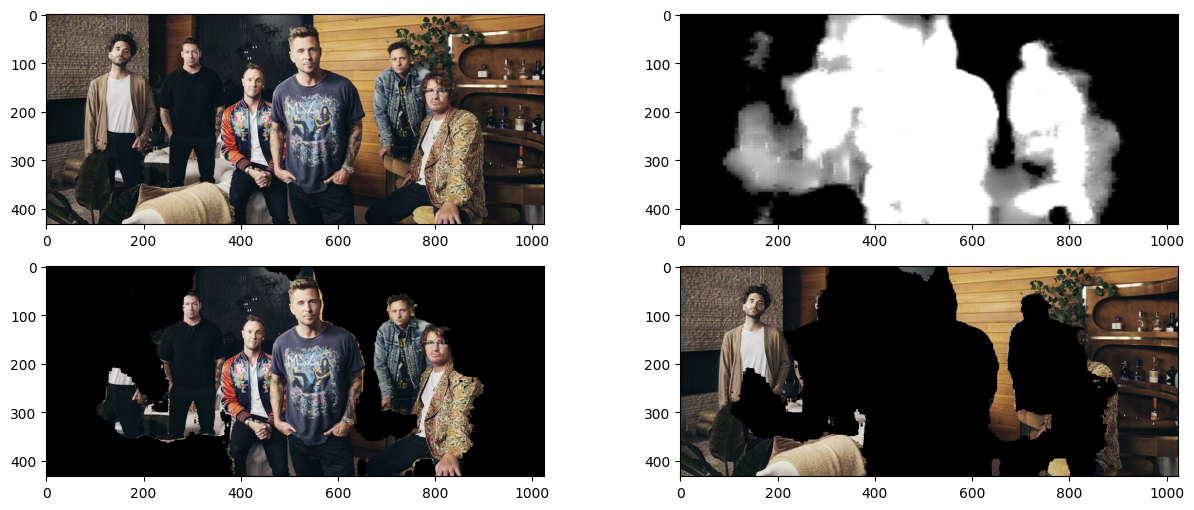

In [15]:
mediapipe_segmentation('./data/one-republic.png')

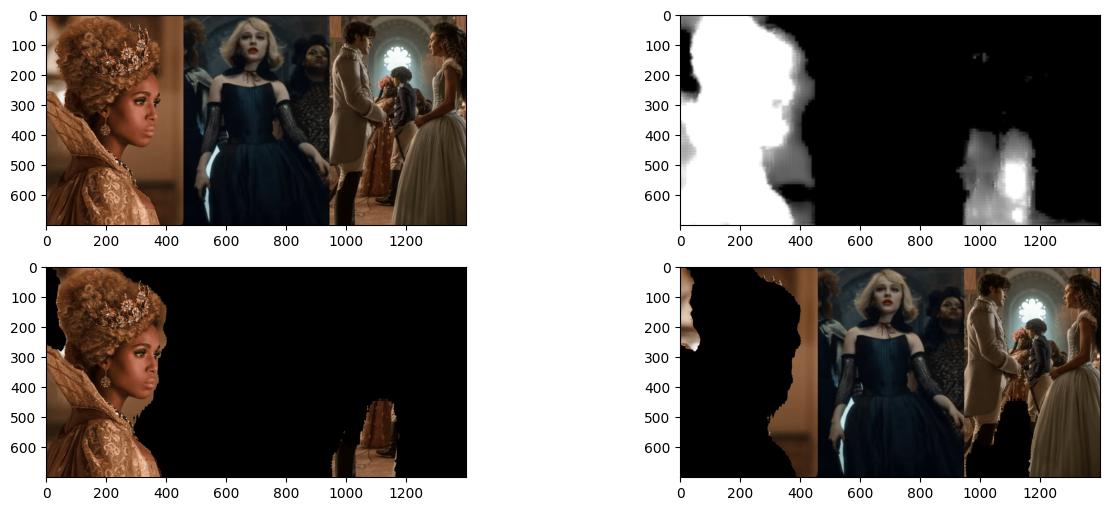

In [17]:
mediapipe_segmentation('./data/sogoe.png')

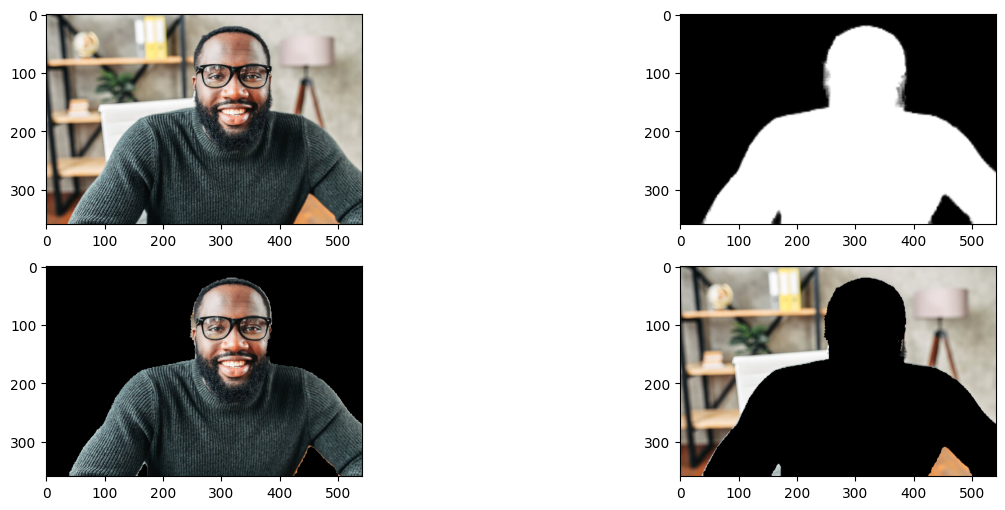

In [18]:
mediapipe_segmentation('./data/wfh1.jpg')

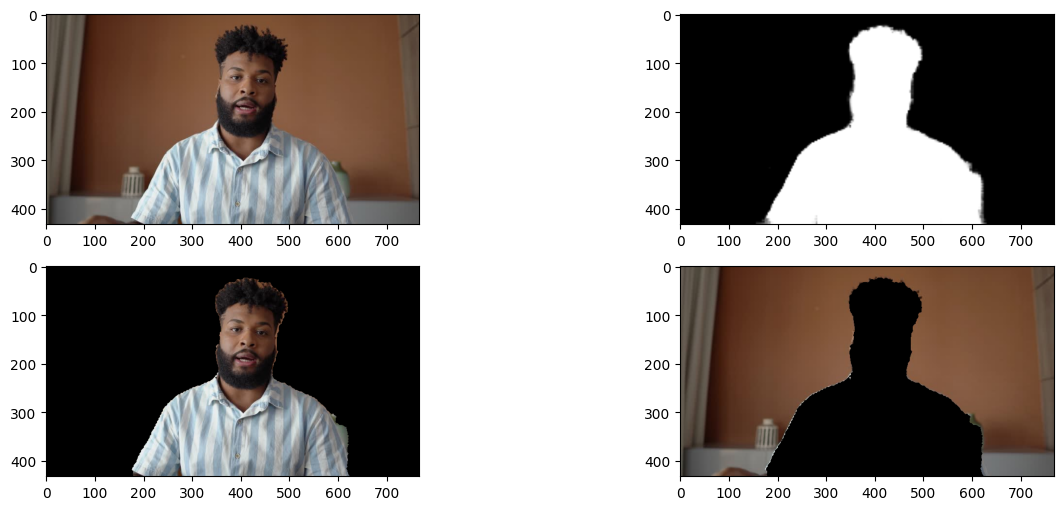

In [19]:
mediapipe_segmentation('./data/wfh2.jpg')

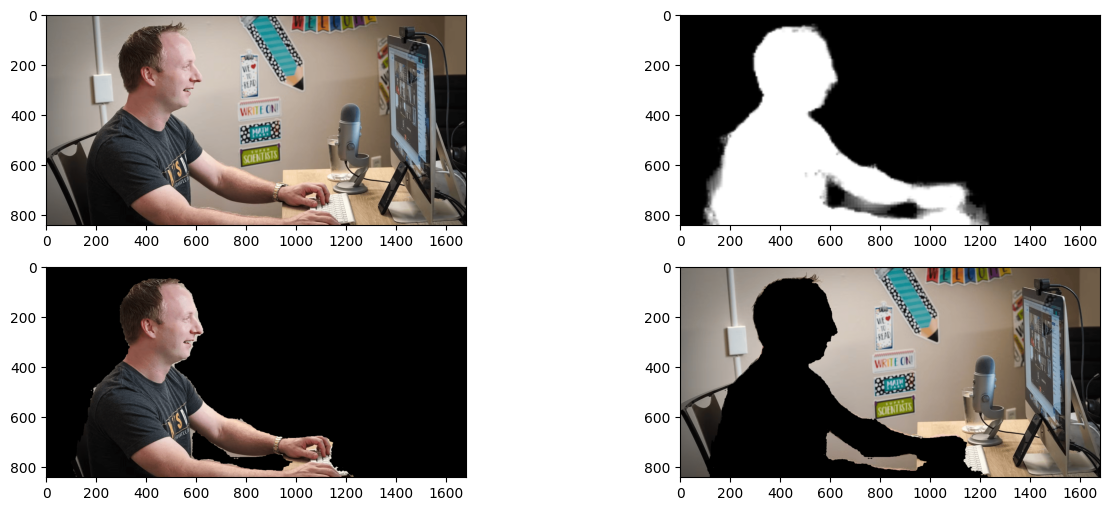

In [20]:
mediapipe_segmentation('./data/wfh3.png')

### Webcam Demo

In [68]:
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

back_image= cv2.imread("./data/background.png")
back_image = cv2.resize(back_image, (1280,720))

def display_mediapipe():
    processing_time = []
    
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    try:
        while True:
            start_time = time.time()
            
            ret, frame = cam.read()
            if not ret:
                print("Failed to capture image.")
                break

            result = selfie_segmentation.process(frame)
            mask = result.segmentation_mask
    
            foreground = frame.copy()
            foreground[mask < 0.5] = 0

            background = back_image.copy()
            background[mask >= 0.5] = 0

            processing_time.append(time.time() - start_time)
            if (len(processing_time) > 20):
                processing_time.pop(0)

            cv2.imshow("Image",foreground+background)

            # Use waitKey with a check for interrupt signal
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        print("Interrupted by user.")
        processing_time = remove_extremes(processing_time)
        print(f"Processing Time: {sum(processing_time)/len(processing_time) * 1000:.2f} ms")
        print(processing_time)
    finally:
        cam.release()
        cv2.destroyAllWindows()


In [69]:
display_mediapipe()

Interrupted by user.
Processing Time: 28.50 ms
[0.022982120513916016, 0.02347397804260254, 0.024020910263061523, 0.024021148681640625, 0.02484917640686035, 0.024882793426513672, 0.024988412857055664, 0.024999618530273438, 0.025000810623168945, 0.025004148483276367, 0.025005578994750977, 0.02502918243408203, 0.026085853576660156, 0.03497195243835449, 0.04108238220214844, 0.05963850021362305]


### Webcam Demo - Soft edges

In [70]:
def refine_mediapipe():
    # set up mediapipe
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    #
    processing_time = []

    # webcam
    cam = cv2.VideoCapture(0)
    default_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
    default_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # background image
    back_image= cv2.imread("./data/background.png")
    back_image = cv2.resize(back_image, (default_width, default_height))

    # erosion kernel
    kernel = np.ones((5, 5), np.uint8)

    try:
        while True:
            start_time = time.time()
            
            ret, frame = cam.read()
            if not ret:
                print("Failed to capture image.")
                break

            result = selfie_segmentation.process(frame)
            mask = result.segmentation_mask
            mask = cv2.erode(mask, kernel, iterations=1) 
            
            foreground = frame.copy()
            foreground[mask < 0.5] = 0

            background = back_image.copy()
            background[mask >= 0.5] = 0

            processing_time.append(time.time() - start_time)
            if (len(processing_time) > 20):
                processing_time.pop(0)

            cv2.imshow("Image",foreground+background)

            # Use waitKey with a check for interrupt signal
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        print("Interrupted by user.")
        processing_time = remove_extremes(processing_time)
        print(f"Processing Time: {sum(processing_time)/len(processing_time) * 1000:.2f} ms")
        print(processing_time)
    finally:
        cam.release()
        cv2.destroyAllWindows()

In [71]:
refine_mediapipe()

Interrupted by user.
Processing Time: 26.05 ms
[0.009960412979125977, 0.009985923767089844, 0.009997129440307617, 0.010004281997680664, 0.010006189346313477, 0.010011672973632812, 0.010288238525390625, 0.010380744934082031, 0.01070261001586914, 0.010991811752319336, 0.011022329330444336, 0.011251211166381836, 0.06383562088012695, 0.06986284255981445, 0.07089567184448242, 0.08759450912475586]


## DeepLab
- [Medium](https://towardsdatascience.com/virtual-background-for-video-conferencing-using-machine-learning-dfba17d90aa9)
    - DeepLab v3
    - Handcrafted using OpenCV + tensorflow, MobileNetV2 as backbone 
- [DeepLab github 1](https://github.com/tensorflow/models/tree/master/research/deeplab)
- [DeepLab github 2](https://github.com/google-research/deeplab2)

### Model Settings

In [17]:
import cv2

import tensorflow as tf
import tempfile
import os
from six.moves import urllib

from io import BytesIO
import tarfile

import numpy as np
from numpy import save
from PIL import Image

import time

In [12]:
background = cv2.imread("./data/background.png")

# Resizing image based on deeplab model 
background = cv2.resize(background, (513,384))

In [13]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

download_path = os.path.join('./model_path' , _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)

downloading model, this might take a while...


('./model_path\\deeplab_model.tar.gz',
 <http.client.HTTPMessage at 0x21d1ff50370>)

In [14]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.compat.v1.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.compat.v1.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):

    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.Resampling.LANCZOS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

def create_pascal_label_colormap():

  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
 
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

LABEL_NAMES = np.asarray([
  'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
  'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
  'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

MODEL = DeepLabModel(os.path.join('./model_path' , _TARBALL_NAME))
print('model loaded successfully!')

### Webcam Demo

In [48]:
cap = cv2.VideoCapture(0)

processing_time = []

try:
    while True:
        start_time = time.time()
        ret, frame = cap.read()
        
        if ret:
            cv2_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_im = Image.fromarray(cv2_im)
          
            # DeepLAb model output
            resized_im, seg_map = MODEL.run(pil_im)
            arr = np.asarray(seg_map)
        
            seg_image = label_to_color_image(seg_map).astype(np.uint8)
            seg_image = seg_image[:,:,0] > 100 
            seg_image = np.uint8(seg_image)*255
            seg_image = cv2.cvtColor(seg_image, cv2.COLOR_GRAY2BGR)
            seg_image = 255 - seg_image
    
            back = np.copy(background)
    
            masked_image = cv2.resize(frame, (513,384))
            masked_image[seg_image != 0] = 0
    
            back[seg_image == 0] = 0
    
            cv2.imshow("Image",masked_image+back)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        processing_time.append(time.time() - start_time)
        if (len(processing_time) > 20):
            processing_time.pop(0)
except KeyboardInterrupt:
    print("Interrupted by user.")
    processing_time = remove_extremes(processing_time)
    print(f"Processing Time: {sum(processing_time)/len(processing_time) * 1000:.2f} ms")
    print(processing_time)
finally:
    cap.release()
    cv2.destroyAllWindows()


Interrupted by user.
Processing Time: 102.25 ms
[0.09262442588806152, 0.09392833709716797, 0.09505176544189453, 0.0952754020690918, 0.09529495239257812, 0.09578204154968262, 0.0969841480255127, 0.09804463386535645, 0.10550212860107422, 0.10649371147155762, 0.10978245735168457, 0.10985732078552246, 0.10996723175048828, 0.1099710464477539, 0.11032605171203613, 0.11118125915527344]


## MediaPipe vs DeepLab
**Features**

| Feature            | MediaPipe                              | DeepLab                                   |
|--------------------|----------------------------------------|------------------------------------------|
| **Application Area** | Real-time processing (background segmentation, pose tracking, etc.) | High-accuracy semantic segmentation (pixel-level scene parsing) |
| **Programming Language** | C++/Python, suitable for cross-platform applications | Python/TensorFlow                        |
| **Execution Speed** | Extremely fast, suitable for low-latency applications | Computationally intensive, suitable for precision segmentation tasks |
| **Model Lightweightness** | Focuses on **lightweight** design, suitable for embedded systems and mobile apps | Larger models, suitable for cloud or high-performance computing environments |
| **Open Source**    | Yes  | Yes |

- Both are developed by Google
- MediaPipe is more lightweight, therefore good for realtime segmentation
- DeepLab focuses more on segmentation accuracy

**Processing Time Comparison** 

Since the camera operates at 30 FPS, to achieve real-time background replacement, the processing time for a single frame should ideally be **no more than 33 ms**.

| Package           | ms/frame   |
|-------------------|------------|
| Web Cam only      | ~25ms      |
| Media Pipe        | ~28ms      |
| DeepLab           | ~102ms     |


## ~~Flow-Based-Video-Segmentation  (April 2021)~~ Can't find suitable data 

Optical Flow + UNet 

**No Pretrained model weight and Data**

- [Paper](https://arxiv.org/abs/2104.09752) 
- [Github](https://github.com/kuangzijian/Flow-Based-Video-Segmentation/tree/master)



## Possible Datasets

[Dataset for Real and Virtual Backgrounds of Video Calls](https://zenodo.org/records/5572910)
- No mask data, can only be used for demo?

[Coco](https://cocodataset.org/#home)
- image, not video
- not webcam image
- many categories, including human

Human Parsing Datasets
- LIP (Look Into Person) Dataset
- CIHP (Crowd Instance-level Human Parsing)
    - human images
- [Google Drive](https://drive.google.com/drive/folders/0BzvH3bSnp3E9QjVYZlhWSjltSWM?resourcekey=0-nkS8bDVjPs3bEw3UZW-omA)

[DAVIS: Densely Annotated VIdeo Segmentation](https://davischallenge.org/index.html)
- not every person is annotated (pic shown in the home page)
- haven't download to check yet
- **video**